In [15]:
import pandas as pd
import numpy as np
import os,sys 
import matplotlib 
import matplotlib.pyplot as plt
import load.wsk_interact as wsk

In [16]:
# Read the two CSVs
# For each function: make a list of its invocation times?
# Compare these metrics in some way and visualize. Sort by function frequency? 

In [17]:
pp='./run-scripts/logs/compare-algos/'
f1='10-mins-5.5-18-BoundedLoad-SimpleLoad/latencies.csv'
f2='10-mins-5.5-18-ConsistentCache-SimpleLoad/latencies.csv'
f4='10-mins-5.5-18-MemoryShard/latencies.csv'
f5='10-mins-5.5-18-RoundRobin-SimpleLoad/latencies.csv'


In [18]:
out=[]
tmp = pd.read_csv(os.path.join(pp, f1))
func_names = tmp["lambda"].unique()
for warm_time, k in zip(wsk.warm_times, wsk.actions):
  for name in func_names:
    if k in name:
      out.append((name,warm_time))


In [19]:
warm_times = pd.DataFrame(out,columns=['lambda',"warm"])

In [20]:
def mean_lats_per_fn(expf):
    df = pd.read_csv(os.path.join(pp, expf), header=0, names=["lambda", "was_cold", "latency", "activationid"])
    ldf = df[['lambda', 'latency']]
    lgrps = ldf.groupby(['lambda'])
    #Also need the length of the list for correct normalization? 
    mean_lats = lgrps.mean()
    return mean_lats, lgrps, ldf, df 

In [21]:
def cmp_lats(f1, f2):
    """ Given two configs, compare the raw mean latencies for each function """
    m1 = mean_lats_per_fn(f1)[0]
    m2 = mean_lats_per_fn(f2)[0]
    merged = m1.merge(m2,on='lambda')
    merged['ldiff'] = pd.Series(merged['latency_y']-merged['latency_x'], index=merged.index)
    return merged 

In [22]:
def Wnorms(expf):
    mean_lats, lgrps, ldf, df = mean_lats_per_fn(expf)
    mean_warm = mean_lats.merge(warm_times,on='lambda')
    mean_warm['norm'] = pd.Series(mean_warm['latency']/mean_warm['warm'], index=mean_warm.index)
    
    counts = lgrps.count()
    counts = counts.rename(columns={'latency':'counts'})
    mean_warm = mean_warm.merge(counts, on='lambda')
    C=sum(mean_warm['counts'])
    mean_warm['Wnorm']=pd.Series(mean_warm['norm']*mean_warm['counts']/C, index=mean_warm.index)
    
    return mean_warm
    #sum(mean_warm['Wnorm'])

In [23]:
from statsmodels.distributions.empirical_distribution import ECDF

In [24]:
bounded=Wnorms(f1)
sum(bounded['Wnorm'])

5922.817559930408

In [25]:
cache=Wnorms(f2)
#np.sort(np.array(b['Wnorm']))
sum(cache['Wnorm'])

1008.1641241962476

In [26]:
mem_shard=Wnorms(f4)
#np.sort(np.array(b['Wnorm']))
sum(mem_shard['Wnorm'])

5211.409226172791

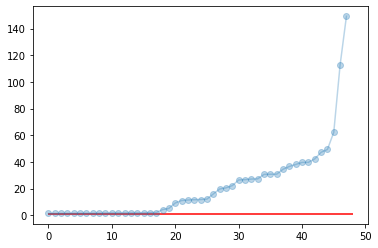

In [27]:
r2_ch_rl = mem_shard['Wnorm']/cache['Wnorm']
plt.hlines(1.0, xmin=0, xmax=len(r2_ch_rl), color='red')
plt.plot(sorted(r2_ch_rl),marker='o',alpha=0.3)


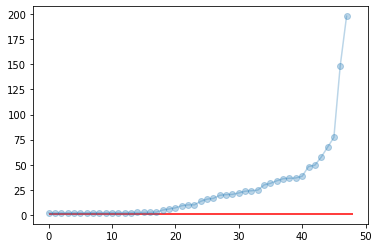

In [28]:
r2_ch_rl = bounded['Wnorm']/cache['Wnorm']
plt.hlines(1.0, xmin=0, xmax=len(r2_ch_rl), color='red')
plt.plot(sorted(r2_ch_rl),marker='o',alpha=0.3)


In [29]:
round_robin=Wnorms(f5)
#np.sort(np.array(b['Wnorm']))
sum(round_robin['Wnorm'])

6927.914937501476

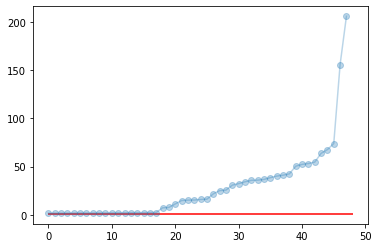

In [30]:
r2_ch_rl = round_robin['Wnorm']/cache['Wnorm']
plt.hlines(1.0, xmin=0, xmax=len(r2_ch_rl), color='red')
plt.plot(sorted(r2_ch_rl),marker='o',alpha=0.3)


In [31]:
r2_ch_rl[r2_ch_rl<1.0]

Series([], Name: Wnorm, dtype: float64)

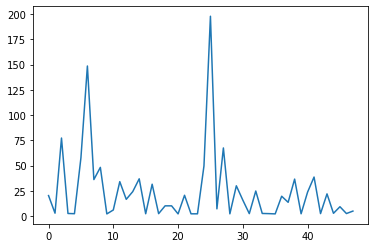

In [32]:
plt.plot((bounded['norm'])/(cache['norm']))